In [3]:
from __future__ import division
import cPickle as pkl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

# Load raw data

In [13]:
def load_data(dump_files):
    """Extract sequences, extra info and patient id from dump pkl."""
    # Positive raw data load
    raw_data = []
    extra_info = []
    indexes = []
    for f in tqdm(dump_files, desc='Loading dump files'):
        _tmp = pkl.load(open(os.path.join('..', 'tmp', f), 'rb'))
        _raw_data, _extra_info = _tmp['raw_data'], _tmp['extra_info'].set_index('PIN')
        for k in _extra_info.index:
            if len(_raw_data[k])>0: # Skip empty sequences
                raw_data.append(_raw_data[k])
                extra_info.append([_extra_info.loc[k]['SEX'], _extra_info.loc[k]['AGE']])
                indexes.append(k)
    return raw_data, extra_info, indexes

In [14]:
dump_files = filter(lambda x: 'raw_data' in x, os.listdir('../tmp/'))
positive_dump_files = filter(lambda x: 'class_1' in x, dump_files)
negative_dump_files = filter(lambda x: 'class_0' in x, dump_files)

In [15]:
pos_raw_data, pos_extra_info, pos_id = load_data(positive_dump_files)
print(len(pos_id), 'positive samples')

Loading dump files: 100%|██████████| 6/6 [00:40<00:00,  6.70s/it]

(23581, 'positive samples')


In [16]:
neg_raw_data, neg_extra_info, neg_id = load_data(negative_dump_files)
print(len(neg_id), 'negative samples')

Loading dump files: 100%|██████████| 1/1 [08:20<00:00, 500.87s/it]

(253161, 'negative samples')


Sequences must be like `['A', 8, 'M', 0, ...]` where letters are btos and numbers are weeks from one btos to another

In [17]:
btos_details = pd.read_csv('../mbspbs10pc/data/btos_details.csv', header=0, index_col=0)
btos_details.head()

,BTOS,BTOS NAME
BTOS (Heirarchy order),,
101,A,Non-referred attendances GP/VR GP
102,M,Non-referred attendances - Enhanced Primary Care
103,B,Non-referred attendances - Other
110,O,Non-referred attendances - Practice Nurse Items
150,P,Other Allied Health


In [9]:
def raw_data_to_BTOS_sequences(raw_data):
    try:
        seq = []
        for btos, td in zip(raw_data[::2], raw_data[1::2]):
            seq.append(btos_details.loc[btos]['BTOS'])
            seq.append(td//7)
        seq.append(btos_details.loc[raw_data[-1]]['BTOS'])
        return seq
    except:
        print(raw_data)

In [18]:
pool = Pool(processes=32)
pos_BTOS_seq = pool.map(raw_data_to_BTOS_sequences, pos_raw_data)
pool.close()

Process PoolWorker-48:
Traceback (most recent call last):
Process PoolWorker-41:
Process PoolWorker-45:
Process PoolWorker-22:
Process PoolWorker-33:
Process PoolWorker-43:
Process PoolWorker-42:
Process PoolWorker-27:
Process PoolWorker-44:
Process PoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-47:
Process PoolWorker-46:
Process PoolWorker-40:
Process PoolWorker-18:
Traceback (most recent call last):
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process PoolWorker-21:
Traceback (most recent call last):
Process PoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-19:
Process PoolWorker-29:
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most

  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samu/miniconda2/lib/python2.7/multip

    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    racquire()
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [ ]:
pool = Pool(processes=32)
neg_BTOS_seq = pool.map(raw_data_to_BTOS_sequences, neg_raw_data)
pool.close()

KeyboardInterrupt


# EDA

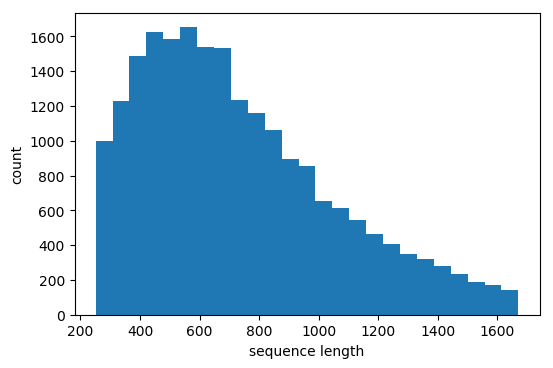

In [53]:
lenghts = np.array([len(x) for x in pos_BTOS_seq])
pos_idx595 = np.argwhere(np.logical_and(lenghts>=np.percentile(lenghts, 5), lenghts<=np.percentile(lenghts, 95))).ravel()
pos_lenghts = lenghts[pos_idx595]

plt.figure(dpi=100)
plt.hist(pos_lenghts, bins=25)
plt.xlabel('sequence length')
plt.ylabel('count');

In [ ]:
lenghts = np.array([len(x) for x in neg_BTOS_seq])
neg_idx595 = np.argwhere(np.logical_and(lenghts>=np.percentile(lenghts, 5), lenghts<=np.percentile(lenghts, 95))).ravel()
neg_lenghts = lenghts[neg_idx595]

plt.figure(dpi=100)
plt.hist(neg_lenghts, bins=25)
plt.xlabel('sequence length')
plt.ylabel('count');

In [24]:
import pandas as pd
imap = pd.read_csv('../mbspbs10pc/data/imap.tsv', sep='\t', header=0, usecols=['ITEM', 'BTOS'])
imap.head()

,ITEM,BTOS
0,1,101
1,2,101
2,3,101
3,4,101
4,5,103


In [25]:
btos = pd.read_csv('../mbspbs10pc/data/btos_details.csv', header=0)
btos.head()

,BTOS (Heirarchy order),BTOS,BTOS NAME
0,101,A,Non-referred attendances GP/VR GP
1,102,M,Non-referred attendances - Enhanced Primary Care
2,103,B,Non-referred attendances - Other
3,110,O,Non-referred attendances - Practice Nurse Items
4,150,P,Other Allied Health


In [30]:
tmp = pd.merge(imap, btos, left_on='BTOS', right_on='BTOS (Heirarchy order)', how='left')[['ITEM', 'BTOS_x', 'BTOS_y']]
tmp = tmp.rename({'BTOS_y': 'BTOS', 'BTOS_x': 'BTOS (Heirarchy order)'}, axis=1)
tmp.head()

,ITEM,BTOS (Heirarchy order),BTOS
0,1,101,A
1,2,101,A
2,3,101,A
3,4,101,A
4,5,103,B


In [31]:
tmp.to_csv('../mbspbs10pc/data/imap_derived.csv')

In [33]:
''.join(['b','s','.'])

'bs.'

In [34]:
''.join([])

''